차량 전체를 보고 학습

fc layer MLP로 구성

## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from glob import glob
import torch
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm import tqdm
import timm
from torchsummaryX import summary
from sklearn.model_selection import train_test_split, StratifiedKFold

from torch.utils.data import Dataset
from torch import nn

## Config

In [2]:
from dotenv import load_dotenv
from setup import get_package_root_path
from src.global_exception_handler.v1 import GlobalExceptionHandler
from src.webhook.v1 import TeamsWebhook

load_dotenv()

pakage_name = os.environ.get("PACKAGE_NAME")
root_path = get_package_root_path()

# 웹훅 알림 url (없으면 빈 문자열)
webhook_url = os.environ.get("WEBHOOK_URL")
webhook = TeamsWebhook(webhook_url)

# 핸들링할 예외 종류
except_tuple = (Exception,)
GlobalExceptionHandler(except_tuple=except_tuple, sender=webhook, name="dacon_cars")

In [3]:
!nvidia-smi

Wed Jun 14 11:52:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:81:00.0 Off |                  Off |
| 59%   82C    P2   289W / 300W |  44102MiB / 49140MiB |     91%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Hyperparameter Setting

In [4]:
class CFG:
    root_path = root_path
    # Job Id (보통 파일명과 동일하게)
    job_id = "CLASSICIATION_2"

    # 원천 데이터 경로
    data_path = f"{root_path}/data/cars"

    # 학습의 결과물이 저장될 경로
    outputs_path = f"{root_path}/outputs/{job_id}"
    predict_dir = f"{outputs_path}/predict"
    recorder_dir = f"{outputs_path}/recorder"

    learning_late = 0.0001
    batch_size = 24
    epoch = 107
    num_classes = 34

    classes = [
        "chevrolet_malibu_sedan_2012_2016",
        "chevrolet_malibu_sedan_2017_2019",
        "chevrolet_spark_hatchback_2016_2021",
        "chevrolet_trailblazer_suv_2021_",
        "chevrolet_trax_suv_2017_2019",
        "genesis_g80_sedan_2016_2020",
        "genesis_g80_sedan_2021_",
        "genesis_gv80_suv_2020_",
        "hyundai_avante_sedan_2011_2015",
        "hyundai_avante_sedan_2020_",
        "hyundai_grandeur_sedan_2011_2016",
        "hyundai_grandstarex_van_2018_2020",
        "hyundai_ioniq_hatchback_2016_2019",
        "hyundai_sonata_sedan_2004_2009",
        "hyundai_sonata_sedan_2010_2014",
        "hyundai_sonata_sedan_2019_2020",
        "kia_carnival_van_2015_2020",
        "kia_carnival_van_2021_",
        "kia_k5_sedan_2010_2015",
        "kia_k5_sedan_2020_",
        "kia_k7_sedan_2016_2020",
        "kia_mohave_suv_2020_",
        "kia_morning_hatchback_2004_2010",
        "kia_morning_hatchback_2011_2016",
        "kia_ray_hatchback_2012_2017",
        "kia_sorrento_suv_2015_2019",
        "kia_sorrento_suv_2020_",
        "kia_soul_suv_2014_2018",
        "kia_sportage_suv_2016_2020",
        "kia_stonic_suv_2017_2019",
        "renault_sm3_sedan_2015_2018",
        "renault_xm3_suv_2020_",
        "ssangyong_korando_suv_2019_2020",
        "ssangyong_tivoli_suv_2016_2020",
    ]


CFG.__dict__

mappingproxy({'__module__': '__main__',
              'root_path': '/data/dacon_cars',
              'job_id': 'CLASSICIATION_2',
              'data_path': '/data/dacon_cars/data/cars',
              'outputs_path': '/data/dacon_cars/outputs/CLASSICIATION_2',
              'predict_dir': '/data/dacon_cars/outputs/CLASSICIATION_2/predict',
              'recorder_dir': '/data/dacon_cars/outputs/CLASSICIATION_2/recorder',
              'learning_late': 0.0001,
              'batch_size': 24,
              'epoch': 107,
              'num_classes': 34,
              'classes': ['chevrolet_malibu_sedan_2012_2016',
               'chevrolet_malibu_sedan_2017_2019',
               'chevrolet_spark_hatchback_2016_2021',
               'chevrolet_trailblazer_suv_2021_',
               'chevrolet_trax_suv_2017_2019',
               'genesis_g80_sedan_2016_2020',
               'genesis_g80_sedan_2021_',
               'genesis_gv80_suv_2020_',
               'hyundai_avante_sedan_2011_2015',
 

## CustomDataset

In [5]:
from sklearn.utils.class_weight import compute_class_weight


class CustomDataset(Dataset):
    def __init__(self, X, y, transforms=None, num_classes: int = None):
        self.X = X
        self.y = y
        self.transforms = transforms
        self.num_classes = num_classes

    def to_categorical(self, y, num_classes):
        """1-hot encodes a tensor"""
        return np.eye(num_classes, dtype="uint8")[y]

    def get_class_weight(self):
        return torch.Tensor(
            compute_class_weight(
                class_weight="balanced", classes=np.unique(self.y), y=self.y
            )
        )

    def __getitem__(self, index):
        img_path = self.X[index]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        if self.y is None:  # if test
            return image, img_path

        # train or valid
        label = self.y[index]
        if self.num_classes is None:
            return image, label, img_path
        else:
            return image, self.to_categorical(label, self.num_classes), img_path

    def __len__(self):
        return len(self.X)

## Transforms

In [54]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        A.ShiftScaleRotate(
            scale_limit=0.01,
            rotate_limit=5,
            p=0.9,
        ),
        A.ToGray(p=1),
        A.HorizontalFlip(),
        A.CLAHE(p=0.5, clip_limit=(1, 15), tile_grid_size=(8, 8)),
        A.Equalize(by_channels=False),
        A.Downscale(
            p=0.5,
            scale_min=0.799999988079071,
            scale_max=0.9900000095367432,
            interpolation=2,
        ),
        A.ElasticTransform(
            p=0.5,
            alpha=0.20000000298023224,
            sigma=3.359999895095825,
            alpha_affine=2.009999990463257,
            interpolation=1,
            border_mode=1,
            value=(0, 0, 0),
            mask_value=None,
            approximate=False,
        ),
        A.GaussNoise(p=0.5, var_limit=(10, 50)),
        A.HueSaturationValue(),
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        A.ToGray(p=1),
        # A.GaussianBlur(blur_limit=(3, 21), p=1),
        # A.HueSaturationValue(),
        # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

## Init dataset

In [55]:
data = None
for i, cls in enumerate(range(CFG.num_classes)):
    data_path_list = sorted(glob(f"{CFG.data_path}/{cls}/*.png"))
    data_path_list = np.expand_dims(np.array(data_path_list), 1)

    labels = np.ones(data_path_list.shape, dtype=np.uint8) * i

    temp = np.concatenate([data_path_list, labels], axis=1)

    data = temp if data is None else np.concatenate([data, temp], axis=0)

In [56]:
df = pd.DataFrame(data)
df.columns = ["path", "label"]
df = df.astype({"path": "string", "label": "int"})
df

,path,label
0,/data/dacon_cars/data/cars/0/syn_00024_2.png,0
1,/data/dacon_cars/data/cars/0/syn_00053_1.png,0
2,/data/dacon_cars/data/cars/0/syn_00060_1.png,0
3,/data/dacon_cars/data/cars/0/syn_00061_1.png,0
4,/data/dacon_cars/data/cars/0/syn_00077_1.png,0
...,...,...
16995,/data/dacon_cars/data/cars/33/syn_06341_0.png,33
16996,/data/dacon_cars/data/cars/33/syn_06347_0.png,33
16997,/data/dacon_cars/data/cars/33/syn_06434_2.png,33
16998,/data/dacon_cars/data/cars/33/syn_06437_0.png,33


In [57]:
for i, cls in enumerate(range(CFG.num_classes)):
    print(f'{cls} : {df[df["label"] == i].shape[0]}')

print("")
print(f"전체 : {df.shape[0]}")

0 : 500
1 : 500
2 : 500
3 : 500
4 : 500
5 : 500
6 : 500
7 : 500
8 : 500
9 : 500
10 : 500
11 : 500
12 : 500
13 : 500
14 : 500
15 : 500
16 : 500
17 : 500
18 : 500
19 : 500
20 : 500
21 : 500
22 : 500
23 : 500
24 : 500
25 : 500
26 : 500
27 : 500
28 : 500
29 : 500
30 : 500
31 : 500
32 : 500
33 : 500

전체 : 17000


## Train / Validation Split

In [58]:
data_fold_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
checker = data_fold_splitter.get_n_splits(X=df, y=df["label"])
print(checker)

5


In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score


def save_pred(saved_path, path, y_true, y_pred, y_prob=None):
    os.makedirs(saved_path)

    df_data = [path, y_true, y_pred]
    df_columns = ["path", "y_true", "y_pred"]

    if y_prob != None:
        df_data.append(y_prob)
        df_columns.append("y_prob")

    df = pd.DataFrame(np.array(df_data).T)
    df.columns = df_columns

    df.to_csv(f"{saved_path}/pred.csv", index=False)

    ### 임시 confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.set(rc={"figure.figsize": (21, 21)})
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    _val_score = f1_score(y_true, y_pred, average="macro")
    plt.xlabel(f"Pred / F1-score: {_val_score:.3f}")
    plt.ylabel("Real")

    classes_point = list(map(lambda x: x + 0.5, range(CFG.num_classes)))
    classes = list(range(CFG.num_classes))
    plt.xticks(classes_point, classes)
    plt.yticks(classes_point, classes)
    plt.savefig(f"{saved_path}/c_matrix.jpg")
    plt.clf()

## Valid

In [60]:
from src.image_eda.v1 import tensor2im
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    confusion_matrix,
)


def valid(model, criterion, data_loader, device):
    model.eval()
    val_loss = []

    epoch_paths = []
    y_true = []
    y_pred = []
    # y_probs = []
    with torch.no_grad():
        for batch_index, (images, labels, paths) in enumerate(tqdm(data_loader)):
            if batch_index % 10 == 0:
                temp_img = images[0].cpu().detach()
                temp_img = tensor2im(temp_img)

                cv2.imwrite(f"{CFG.root_path}/temp/val_img.jpg", temp_img)

            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            probs = model(images)
            loss = criterion(probs, labels)

            probs = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            preds = np.argmax(probs, 1).astype(np.uint8)
            labels = np.argmax(labels, 1).astype(np.uint8)

            preds = preds.flatten()
            labels = labels.flatten()

            y_pred += preds.tolist()
            y_true += labels.tolist()
            # y_probs += probs.tolist()
            epoch_paths += paths

            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_score = accuracy_score(y_true, y_pred)

    return {
        "val_loss": val_loss,
        "val_score": val_score,
        "path": epoch_paths,
        "y_true": y_true,
        "y_pred": y_pred,
    }

## Train

In [61]:
def train(model, criterion, optimizer, data_loader, device, grad_scaler=None):
    model.train()
    train_loss = []

    epoch_paths = []
    y_true = []
    y_pred = []
    for batch_index, (images, labels, paths) in enumerate(tqdm(data_loader)):
        if batch_index % 10 == 0:
            temp_img = images[0].cpu().detach()
            temp_img = tensor2im(temp_img)

            cv2.imwrite(f"{CFG.root_path}/temp/training_img.jpg", temp_img)

        images = images.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        if grad_scaler is None:
            probs = model(images)
            loss = criterion(probs, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                probs = model(images)
                loss = criterion(probs, labels)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

        probs = probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        preds = np.argmax(probs, 1).astype(np.uint8)
        labels = np.argmax(labels, 1).astype(np.uint8)

        preds = preds.flatten()
        labels = labels.flatten()

        y_pred += preds.tolist()
        y_true += labels.tolist()
        epoch_paths += paths

        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_score = accuracy_score(y_true, y_pred)

    return {
        "train_loss": train_loss,
        "train_score": train_score,
    }

## Model Define

In [62]:
def create_model(num_classes: int) -> nn.Module:
    # model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.DEFAULT)
    # model.classifier = nn.Sequential(nn.Linear(2048, num_classes), nn.Softmax())

    # model = timm.models.eva.eva02_base_patch14_448(pretrained=True)
    # model.head = nn.Sequential(
    #     nn.Linear(768, ),
    #     nn.BatchNorm1d(),
    #     nn.GELU(),
    #     nn.Dropout(0.5),
    #     nn.Linear(768, num_classes),
    # )

    # model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.DEFAULT)
    # model.classifier[2] = nn.Sequential(
    #     nn.Linear(1536, 1024),
    #     nn.LayerNorm(1024),
    #     nn.SiLU(),
    #     nn.Dropout1d(0.5),
    #     nn.Linear(1024, num_classes),
    # )

    model = timm.models.convnext.convnext_base(pretrained=True)
    model.head.fc = nn.Sequential(
        nn.Linear(1024, 768),
        nn.LayerNorm(768),
        nn.SiLU(),
        nn.Dropout(0.5),
        nn.Linear(768, num_classes),
    )

    return model


create_model(34)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

## Snapshot Notebook

In [63]:
import shutil

try:
    import IPython

    notebook_path = IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
except:
    notebook_path = f"{os.getcwd()}/{CFG.job_id}.ipynb"


os.makedirs(CFG.outputs_path, exist_ok=True)
shutil.copy(notebook_path, f"{CFG.outputs_path}/{os.path.split(notebook_path)[1]}")

'/data/dacon_cars/outputs/CLASSICIATION_2/CLASSICIATION_2.ipynb'

## Run!!

In [64]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [65]:
from src.random_seed.v1 import seed_everything, seed_worker

seed_everything(0)

In [66]:
grad_scaler = torch.cuda.amp.GradScaler()

In [67]:
from src.recorder.v1 import Recorder
from time import time


for fold_index, (train_idx, valid_idx) in enumerate(
    data_fold_splitter.split(X=df, y=df["label"])
):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[valid_idx]

    train_dataset = CustomDataset(
        train_df["path"].values,
        train_df["label"].values,
        train_transform,
        CFG.num_classes,
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.batch_size * 2,  #
        pin_memory=True,
        drop_last=False,
        worker_init_fn=seed_worker,
    )
    #
    val_dataset = CustomDataset(
        val_df["path"].values, val_df["label"].values, val_transform, CFG.num_classes
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.batch_size * 2,
        pin_memory=True,
        drop_last=False,
        worker_init_fn=seed_worker,
    )
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=CFG.learning_late)
    scheduler = None

    recorder = Recorder(
        f"{CFG.recorder_dir}/fold_{fold_index}", model, optimizer, scheduler
    )
    print(f"fold_{fold_index} start")
    if recorder.load_checkpoint(device, "checkpoint.pt"):
        print(f"loaded current_epoch: {recorder.current_epoch}")

    criterion = nn.CrossEntropyLoss().to(device)

    best_val_loss = 100
    for epoch_index in range(recorder.current_epoch, CFG.epoch):
        seed_everything(epoch_index)

        train_start_timestamp = time()
        train_dict = train(
            model, criterion, optimizer, train_loader, device, grad_scaler
        )
        train_elapsed_time = time() - train_start_timestamp

        val_start_timestamp = time()
        val_dict = valid(model, criterion, val_loader, device)
        val_elapsed_time = time() - val_start_timestamp

        recorder.update_row_dict("epoch", epoch_index + 1)

        recorder.update_row_dict("train_loss", train_dict["train_loss"])
        recorder.update_row_dict("val_loss", val_dict["val_loss"])

        recorder.update_row_dict("train_score", train_dict["train_score"])
        recorder.update_row_dict("val_score", val_dict["val_score"])

        recorder.update_row_dict("train_elapsed_time", train_elapsed_time)
        recorder.update_row_dict("val_elapsed_time", val_elapsed_time)
        recorder.flush_row_dict(is_print=True)
        recorder.save_line_plot(["loss"], [0, 0.1])

        save_pred(
            f"{CFG.predict_dir}/fold_{fold_index}/{epoch_index}",
            val_dict["path"],
            val_dict["y_true"],
            val_dict["y_pred"],
        )

        if recorder.is_best_score(val_dict["val_loss"], "min"):
            print(f"best epoch: {epoch_index + 1}")
            recorder.save_checkpoint(epoch_index, "best_model.pt")

        recorder.save_checkpoint(epoch_index)

fold_0 start
loaded current_epoch: 105


100%|██████████| 142/142 [00:46<00:00,  3.04it/s]


epoch: 106, train_loss: 0.001209222105219328, val_loss: 0.0009164525388974864, train_score: 0.9999264705882352, val_score: 0.9997058823529412, train_elapsed_time: 184.2148675918579, val_elapsed_time: 46.73166513442993


100%|██████████| 142/142 [00:46<00:00,  3.04it/s]


epoch: 107, train_loss: 4.0843921395021805e-05, val_loss: 0.0010864937259766425, train_score: 1.0, val_score: 0.9997058823529412, train_elapsed_time: 184.0151834487915, val_elapsed_time: 46.75787663459778
fold_1 start
loaded current_epoch: 105


100%|██████████| 142/142 [00:46<00:00,  3.07it/s]


epoch: 106, train_loss: 0.0046107659820293755, val_loss: 0.00017226767634761467, train_score: 0.9994852941176471, val_score: 1.0, train_elapsed_time: 184.52343654632568, val_elapsed_time: 46.31763243675232


100%|██████████| 142/142 [00:46<00:00,  3.06it/s]


epoch: 107, train_loss: 6.400119588750873e-05, val_loss: 1.7723902583960629e-06, train_score: 1.0, val_score: 1.0, train_elapsed_time: 183.96949791908264, val_elapsed_time: 46.44442391395569
best epoch: 107
fold_2 start
loaded current_epoch: 105


100%|██████████| 142/142 [00:46<00:00,  3.05it/s]


epoch: 106, train_loss: 6.243770682622888e-06, val_loss: 8.55451148941285e-07, train_score: 1.0, val_score: 1.0, train_elapsed_time: 184.6729519367218, val_elapsed_time: 46.60282373428345
best epoch: 106


100%|██████████| 142/142 [00:48<00:00,  2.92it/s]


epoch: 107, train_loss: 0.0028973601646040984, val_loss: 4.4189037602093226e-05, train_score: 0.9997058823529412, val_score: 1.0, train_elapsed_time: 183.7454686164856, val_elapsed_time: 48.67085862159729
fold_3 start
loaded current_epoch: 105


100%|██████████| 142/142 [00:48<00:00,  2.91it/s]


epoch: 106, train_loss: 7.857016342753236e-06, val_loss: 1.1407934475131133e-06, train_score: 1.0, val_score: 1.0, train_elapsed_time: 185.13092517852783, val_elapsed_time: 48.864904165267944
best epoch: 106


100%|██████████| 142/142 [00:46<00:00,  3.04it/s]


epoch: 107, train_loss: 0.0054822252694201, val_loss: 6.441134661132233e-06, train_score: 0.9989705882352942, val_score: 1.0, train_elapsed_time: 184.92219924926758, val_elapsed_time: 46.678730964660645
fold_4 start
loaded current_epoch: 105


100%|██████████| 142/142 [00:47<00:00,  3.01it/s]


epoch: 106, train_loss: 0.006816519143823763, val_loss: 0.0003342979327057114, train_score: 0.9990441176470588, val_score: 1.0, train_elapsed_time: 185.56657481193542, val_elapsed_time: 47.117799520492554


100%|██████████| 142/142 [00:47<00:00,  3.00it/s]


epoch: 107, train_loss: 0.0001789920655116878, val_loss: 7.806795490299483e-06, train_score: 1.0, val_score: 1.0, train_elapsed_time: 184.11705708503723, val_elapsed_time: 47.31684327125549


<Figure size 2100x2100 with 0 Axes>

## Test

In [77]:
test_transform = A.Compose(
    [
        A.PadIfNeeded(
            456,
            456,
            border_mode=0,
            value=(0, 0, 0),
        ),
        # A.Sharpen(p=1),
        # A.RandomBrightnessContrast(p=1),
        A.ToGray(p=1),
        # A.CLAHE(p=1),
        A.Equalize(p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)

In [78]:
model_list = []
import ttach as tta

tta_transforms = tta.Compose(
    [
        # tta.FiveCrops(350, 350),
        # tta.Rotate90(angles=[0, 180]),
        # tta.Scale(scales=[1, 2, 4]),
        # tta.Multiply(factors=[0.9, 1, 1.1]),
        tta.HorizontalFlip()
    ]
)

for i in range(0, 5):
    model = create_model(CFG.num_classes)
    model.to(device)
    model.cuda()

    check_point = torch.load(
        f"{CFG.recorder_dir}/fold_{i}/checkpoint.pt",
        map_location=device,
    )
    print(check_point["epoch"])
    print(check_point["best_score"])
    model.load_state_dict(check_point["model"])
    model.eval()
    tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
    model_list.append(tta_model)

# for i in range(0, 5):
#     model = create_model(CFG.num_classes)
#     model.to(device)
#     model.cuda()

#     check_point = torch.load(
#         f"{CFG.recorder_dir}/fold_{i}/checkpoint.pt",
#         map_location=device,
#     )
#     print(check_point["epoch"])
#     print(check_point["best_score"])
#     model.load_state_dict(check_point["model"])
#     model.eval()
#     tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
#     model_list.append(tta_model)

107
2.091903073164758e-05
107
1.7723902583960629e-06
107
8.55451148941285e-07
107
1.1407934475131133e-06
107
2.163614729631301e-06


In [79]:
test_index = 125

/data/dacon_cars/data/test_cars/075135239_0.png
125
(252, 266, 3)
[[1.40000007e-03 5.20000001e-03 1.12000005e-02 4.00000019e-04
  1.26000000e-02 7.19999988e-03 1.91000000e-01 2.00000009e-04
  8.42000023e-02 6.28000051e-02 2.40000011e-03 0.00000000e+00
  1.12199999e-01 8.60000029e-03 5.40000014e-03 5.59999980e-03
  0.00000000e+00 0.00000000e+00 3.39999981e-03 3.56800020e-01
  7.59999966e-03 0.00000000e+00 1.60000008e-03 1.70000009e-02
  6.00000028e-04 0.00000000e+00 6.00000028e-04 6.00000028e-04
  1.40000007e-03 1.59999984e-03 5.20000001e-03 8.42000023e-02
  8.00000038e-04 6.99999928e-03]]
0.35680002
19
kia_k5_sedan_2020_


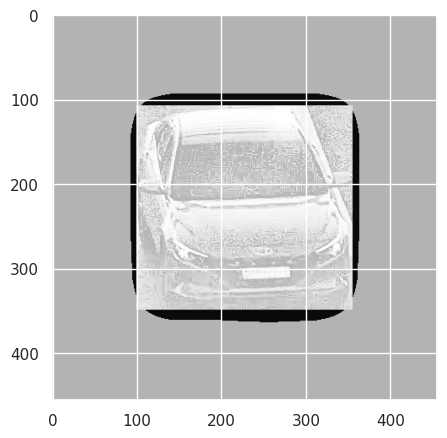

In [85]:
from torch.nn import functional as F


test_list = sorted(glob("/data/dacon_cars/data/test_cars/*.png"))
# test_list = sorted(glob("/data/dacon_cars/data/test_cars/134354918_0.png"))
print(test_list[test_index])
print(test_index)
img = cv2.cvtColor(cv2.imread(test_list[test_index]), cv2.COLOR_BGR2RGB)
# test_index += 1
with torch.no_grad():
    print(img.shape)
    img = img[5:-5, 5:-5]
    test_img = test_transform(image=img)["image"]
    test_img = torch.Tensor(test_img).to(device, dtype=torch.float)
    test_img = torch.unsqueeze(test_img, 0)
    ensemble_probs = None
    for tta_model in model_list:
        probs = F.softmax(tta_model(test_img), dim=1)
        probs = np.round(probs.cpu().detach().numpy(), 3)

        if ensemble_probs is None:
            ensemble_probs = probs
        else:
            ensemble_probs = ensemble_probs + probs

    ensemble_probs = ensemble_probs / len(model_list)
    top1 = np.max(ensemble_probs)
    label = np.argmax(ensemble_probs)
    print(ensemble_probs)
    print(top1)
    print(label)
    print(CFG.classes[label])
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor2im(test_img[0]))
    # f"{test_path}/test"

In [27]:
bbox_submit = pd.read_csv("/data/dacon_cars/data/bbox_submit.csv")
filenames = sorted(os.listdir("/data/dacon_cars/data/test"))

total_list = []
for target in tqdm(iter(filenames)):
    car_info_df = bbox_submit[
        (bbox_submit["file_name"] == target)
        & ((bbox_submit["point3_x"] - bbox_submit["point1_x"]) <= 370)
        & ((bbox_submit["point3_y"] - bbox_submit["point1_y"]) <= 441)
    ]
    # print(one_test)

    infer_list = []
    for i, car_info in car_info_df.iterrows():
        file_name = car_info["file_name"]
        img = cv2.cvtColor(
            cv2.imread(f"/data/dacon_cars/data/test/{file_name}"),
            cv2.COLOR_BGR2RGB,
        )
        pt1x = int(np.round(car_info["point1_x"])) + 5
        pt1y = int(np.round(car_info["point1_y"])) + 5
        pt2x = int(np.round(car_info["point2_x"])) - 5
        pt2y = int(np.round(car_info["point2_y"])) + 5
        pt3x = int(np.round(car_info["point3_x"])) - 5
        pt3y = int(np.round(car_info["point3_y"])) - 5
        pt4x = int(np.round(car_info["point4_x"])) + 5
        pt4y = int(np.round(car_info["point4_y"])) - 5

        img = img[pt1y:pt3y, pt1x:pt3x]
        with torch.no_grad():
            img = test_transform(image=img)["image"]
            img = torch.Tensor(img).to(device, dtype=torch.float)
            img = torch.unsqueeze(img, 0)
            ensemble_probs = None
            for tta_model in model_list:
                probs = F.softmax(tta_model(img), dim=1)
                probs = np.round(probs.cpu().detach().numpy(), 3)

                if ensemble_probs is None:
                    ensemble_probs = probs
                else:
                    ensemble_probs = ensemble_probs + probs

            ensemble_probs = ensemble_probs / len(model_list)

        class_id = np.argmax(ensemble_probs)
        confidence = ensemble_probs[0][class_id]

        infer_list.append(
            [
                file_name,
                class_id,
                confidence,
                pt1x,
                pt1y,
                pt2x,
                pt2y,
                pt3x,
                pt3y,
                pt4x,
                pt4y,
            ]
        )

    infer_array = np.array(infer_list)
    try:
        max_confidence_list = infer_array[np.argmax(infer_array.T[2])].tolist()
    except:
        print(car_info)

    total_list.append(max_confidence_list)

3400it [12:14,  4.63it/s]


In [30]:
submit_df = pd.DataFrame(
    total_list,
    columns=[
        "file_name",
        "class_id",
        "confidence",
        "point1_x",
        "point1_y",
        "point2_x",
        "point2_y",
        "point3_x",
        "point3_y",
        "point4_x",
        "point4_y",
    ],
)
submit_df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,064442001.png,16,1.0,1140,180,1434,180,1434,496,1140,496
1,064507368.png,16,0.9948,493,125,763,125,763,428,493,428
2,065131036.png,3,1.0,1111,57,1361,57,1361,319,1111,319
3,065147868.png,16,1.0,728,187,1014,187,1014,499,728,499
4,065203472.png,8,1.0,538,765,833,765,833,1046,538,1046
...,...,...,...,...,...,...,...,...,...,...,...
3395,183730886.png,1,1.0,1324,598,1620,598,1620,873,1324,873
3396,183744509.png,1,1.0,913,695,1207,695,1207,982,913,982
3397,183911746.png,27,1.0,755,273,1006,273,1006,560,755,560
3398,183928410.png,27,1.0,688,51,919,51,919,305,688,305


In [31]:
submit_df.to_csv("/data/submit.csv", index=False)

In [33]:
submit2_df = pd.read_csv("/data/submit3.csv")

In [34]:
compare_df = pd.concat(
    [submit_df["file_name"], submit_df["class_id"], submit2_df["class_id"]],
    axis=1,
)

# compare_df = pd.merge(
#     submit_df[["file_name", "class_id"]],
#     submit2_df[["file_name", "class_id"]],
#     how="outer",
#     left_index=True,
#     right_index=True,
#     indicator=True,
# )

compare_df.columns = ["file_name", "class_id1", "class_id2"]
# print(compare_df)
print(compare_df)
compare_df.to_csv("/data/temp.csv")

          file_name class_id1  class_id2
0     064442001.png        16         16
1     064507368.png        16         16
2     065131036.png         3          3
3     065147868.png        16         16
4     065203472.png         8          8
...             ...       ...        ...
3395  183730886.png         1          1
3396  183744509.png         1          1
3397  183911746.png        27         27
3398  183928410.png        27         27
3399  184121675.png        27         27

[3400 rows x 3 columns]


In [45]:
len(compare_df)

compare_df.loc[1]["class_id2"]

16

In [48]:
for i in range(len(compare_df)):
    temp = compare_df.loc[i]

    if temp["class_id1"] != temp["class_id2"]:
        print(temp["class_id1"])
        print(temp["class_id2"])
        print(temp)

16
16
file_name    064442001.png
class_id1               16
class_id2               16
Name: 0, dtype: object
16
16
file_name    064507368.png
class_id1               16
class_id2               16
Name: 1, dtype: object
3
3
file_name    065131036.png
class_id1                3
class_id2                3
Name: 2, dtype: object
16
16
file_name    065147868.png
class_id1               16
class_id2               16
Name: 3, dtype: object
8
8
file_name    065203472.png
class_id1                8
class_id2                8
Name: 4, dtype: object
16
16
file_name    065223169.png
class_id1               16
class_id2               16
Name: 5, dtype: object
33
33
file_name    065330905.png
class_id1               33
class_id2               33
Name: 6, dtype: object
33
33
file_name    065331262.png
class_id1               33
class_id2               33
Name: 7, dtype: object
3
3
file_name    065425441.png
class_id1                3
class_id2                3
Name: 8, dtype: object
16
16
file_name 